In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

#Prophet Model Stuff
!pip install fbprophet --quiet

from fbprophet import Prophet
from fbprophet.plot import plot_plotly
from fbprophet.plot import plot_yearly
from fbprophet.plot import add_changepoints_to_plot
import plotly.offline as py
py.init_notebook_mode()

# Prophet

I am building this notebook to practice implementing Facebook's Prophet model on some real-world time series data.

---

Prophet was released by Facebook’s Core Data Science team on September 27, 2017, with the goal of "producing reliable and high-quality forecasts." It aims to bridge the gap between analysts and time series modeling. 

The model itself is an additive model which combines non-linear trends with multiple seasonalities and holiday effects to make its predictions. 

The model works best with data that has a strong seasonality effect and with several seasons of data. The model can also handle missing data and outliers.

Some additional noteworthy benefits of the model include the following.

- Custom seasonalities
- Multiple seasonalities
- Robust to outliers + missing data
- Highly tunable
- Accurate + Fast


#### Useful Resources

- [Forecasting at Scale (Prophet Paper)](https://peerj.com/preprints/3190/)
- [Prophet Documentation](https://facebook.github.io/prophet/)
- [Facebook's Prophet Blog Post](https://research.facebook.com/blog/2017/02/prophet-forecasting-at-scale/)
- [Prophet Forecasting Notebook](https://www.kaggle.com/code/prashant111/tutorial-time-series-forecasting-with-prophet)
- [Konrad's TS-2: Linear Vision](https://www.kaggle.com/code/konradb/ts-2-linear-vision)

Thank you to [Konrad Banachewicz](https://www.kaggle.com/konradb) for sharing the practical time series methods notebooks. This collection of notebooks is a must-watch/must-read for those working with time-series data.

## Loading Data

For this notebook, we will attempt to predict the S&P500 index value. The three CSV files in the dataset include S&P500 company information, S&P500 stock information, and the S&P index value.

The data used in this article can be found at the following link.

[S&P 500 Stocks (daily updated) Dataset](https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks)

Let's first load this data into Pandas.

In [2]:
companies = pd.read_csv("../input/sp-500-stocks/sp500_companies.csv")
sp = pd.read_csv("../input/sp-500-stocks/sp500_index.csv")
sp_all = pd.read_csv("../input/sp-500-stocks/sp500_stocks.csv")

sp['Date'] = pd.to_datetime(sp['Date'])
sp_all['Date'] = pd.to_datetime(sp_all['Date'])

sp.head()

Date   S&P500
0 2012-05-03  1391.57
1 2012-05-04  1369.10
2 2012-05-07  1369.58
3 2012-05-08  1363.72
4 2012-05-09  1354.58

Next, let's visualize the entirety of the S&P500 index value dataset. This data is a great example of real-world time-series data that is not easy to predict.

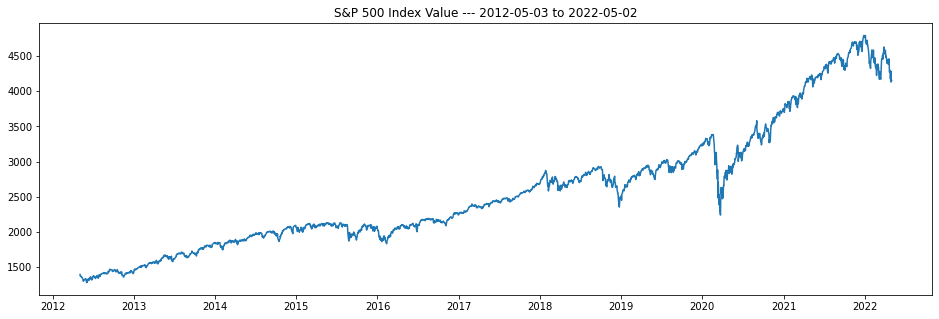

In [3]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    plt.figure(figsize=(16,5))
    plt.title("S&P 500 Index Value --- {} to {}".format(sp['Date'].min().date(), sp['Date'].max().date()))
    plt.plot(sp['Date'], sp['S&P500'])
    plt.locator_params(axis="x", nbins=15)
    plt.show(sns)

## Processing the Data

We will only train on data from 2016 through 2020. We will then use the month of January 2021 to evaluate the model performance. It is common practice to train on only recent years of market data for stock predictions yet I can not find a solid reason for this practice<sup>1</sup>.

The input data for the Prophet model must have the timestamp column labeled as ds, and the value column labeled as y.

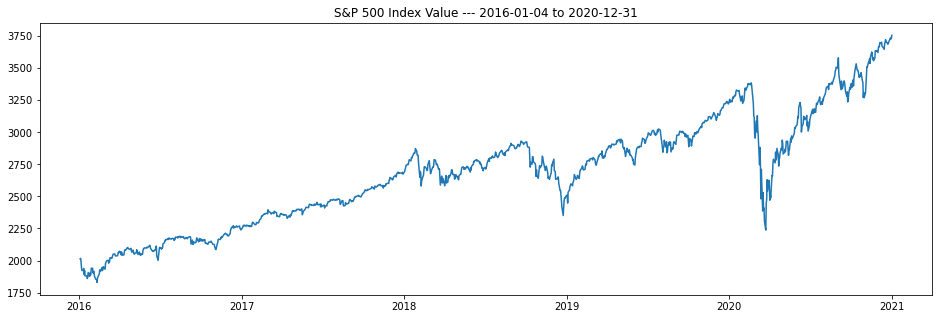

In [4]:
sp = sp.rename(columns={'Date': 'ds','S&P500': 'y'})
sp_sample = sp[(sp.ds.dt.year>=2016) & (sp.ds.dt.year<2021)].reset_index(drop=True).sort_values("ds")

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    plt.figure(figsize=(16,5))
    plt.title("S&P 500 Index Value --- {} to {}".format(sp_sample['ds'].min().date(), sp_sample['ds'].max().date()))
    plt.plot(sp_sample['ds'].dt.to_pydatetime(), sp_sample['y'])
    plt.show(sns)

## Prophet Model

In the following cell, we are first simply instantiating the prophet model. The interval_width parameter specifies the confidence interval in our forecast which we have set to 95% (default = 80%).

Next, we are adding holiday information into the forecast. Prophet has a built-in collection of country-specific holidays, and therefore we simply have to pass in 'US' to get the holidays for the United States. We can also manually enter these days if need be.

Finally, we simply call model.fit() on our data to train the model.

In [5]:
model1 = Prophet(interval_width=0.95)
model1.add_country_holidays(country_name='US')
model1.fit(sp_sample)

Initial log joint probability = -5.28897


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3654.94    0.00674593       374.647           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187        3663.7   0.000260594       248.968   1.788e-06       0.001      246  LS failed, Hessian reset 
     199       3664.58    0.00241411       121.308           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3676.55     0.0126367       217.922           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     327       3677.47   5.88621e-05        124.36   3.867e-07       0.001      469  LS failed, Hessian reset 
     399       3679.45   0.000648541       91.7359           1           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha

In the next cell, we then produce a forecast for the data. The period's parameter is the number of periods in the future we want to predict, and the frequency is how often predictions should be made. In our case, the stock market is only open on business days, and therefore we want to use 'B' (AKA. business day frequency). A complete list of frequency parameter options can be found [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).

The predict functions return a number of columns, but the most important are the yhat, yhat_lower, and yhat_upper columns. 

- ***yhat***: The forecasted value
- ***yhat_lower***: The lower bound of y_hat for the specified confidence interval
- ***yhat_upper***:  The upper bound of y_hat for the specified confidence interval

In our case, we specified a confidence interval of 95%, and therefore we expect 95% of all the points to fall within yhat_lower and yhat_upper.

In [6]:
future = model1.make_future_dataframe(periods=30, freq="B")
forecast = model1.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower   yhat_upper
1284 2021-02-05  3627.033193  3409.980845  3850.349092
1285 2021-02-08  3626.820683  3420.987715  3850.266668
1286 2021-02-09  3631.901771  3413.537499  3841.695259
1287 2021-02-10  3630.922283  3420.509148  3833.900824
1288 2021-02-11  3631.669909  3432.386768  3826.863197

We can then use Prophet's built-in .plot() function to visualize the original data along with the future predicted values.

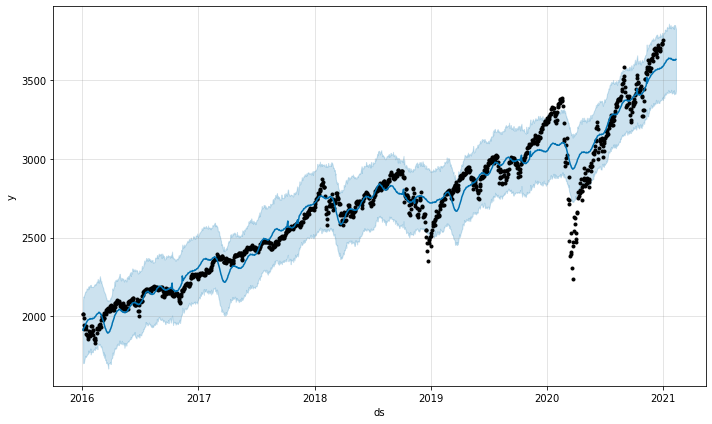

In [7]:
fig = model1.plot(forecast)

The plot above is great to get a view of the original data points, but the forecasted values are difficult to see. Therefore we can not really evaluate the magnitude and accuracy of our predictions.

I created a modified version of Prophet's plot function in the cell below. This function is simply plotting 150 days of data. 120 of these days are the ones that we trained the model on, and the final 30 days are our model predictions.

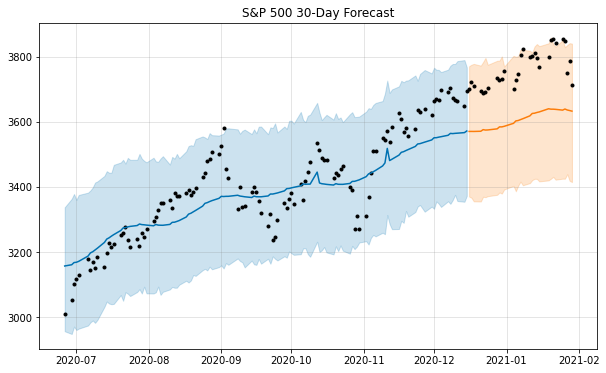

In [8]:
def custom_forecast_plot():
    forecast_length = 30

    prior_df = sp[(sp.ds.dt.year>=2016) & (sp.ds.dt.year<2021)]
    forecast_df = sp[(sp.ds.dt.year==2021) & (sp.ds.dt.month==1)]
    all_df = pd.concat([prior_df, forecast_df]).sort_values('ds')
    all_df.head()

    all_df_sample = all_df[-forecast_length*5:]
    forecast_sample = forecast[forecast['ds'].isin(all_df["ds"].values)].sort_values('ds')

    prior_vis_df = forecast_sample[-forecast_length*5:-forecast_length]
    forecast_vis_df = forecast_sample[-forecast_length:]

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)

    ax.plot(all_df_sample['ds'].dt.to_pydatetime(), all_df_sample["y"], '.k')

    ax.plot(prior_vis_df['ds'].dt.to_pydatetime(), prior_vis_df['yhat'], ls='-', c='#0072B2')
    ax.fill_between(prior_vis_df['ds'].dt.to_pydatetime(), prior_vis_df['yhat_lower'], prior_vis_df['yhat_upper'], color='#0072B2', alpha=0.2)

    ax.plot(forecast_vis_df['ds'].dt.to_pydatetime(), forecast_vis_df['yhat'], ls='-', c='#fc7d0b')
    ax.fill_between(forecast_vis_df['ds'].dt.to_pydatetime(), forecast_vis_df['yhat_lower'], forecast_vis_df['yhat_upper'], color='#fc7d0b', alpha=0.2)
    ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)

    ax.set_title('S&P 500 30-Day Forecast')
    plt.show(sns)
    
custom_forecast_plot()

We can see from the plot above that our predictions are slightly under what the true labels are. That being said, all but 1 of the 30 points stayed within the 95% confidence interval of the model. That's pretty good considering we are making all of these predictions 30 days in advance!

#### Breaking Down the Model

In the next plot, we can break down the model even further. The first plot shows that apart from late 2019, the S&P 500 index value has a positive trend over time.

The second plot shows the effect of holidays on the data. We can see that for all but two of the holidays it seems that the value increases. It is important to note that the stock market closes on major holidays, and therefore the effect of these events may be reflected by the market on the days before and after the event.

The third plot shows that there is very little difference between each weekday in terms of how it affects the S&P 500 index value. Note that trades are not done on Saturday or Sunday so these values do not give us any additional information.

Finally, we can see that the model sees a downward trend from February to March, whereas the other months are when the index value increases. This suggests that the model could be overfitting to the seasonality of the training data, or the stock market could have a moderate yearly seasonality<sup>2</sup>. 

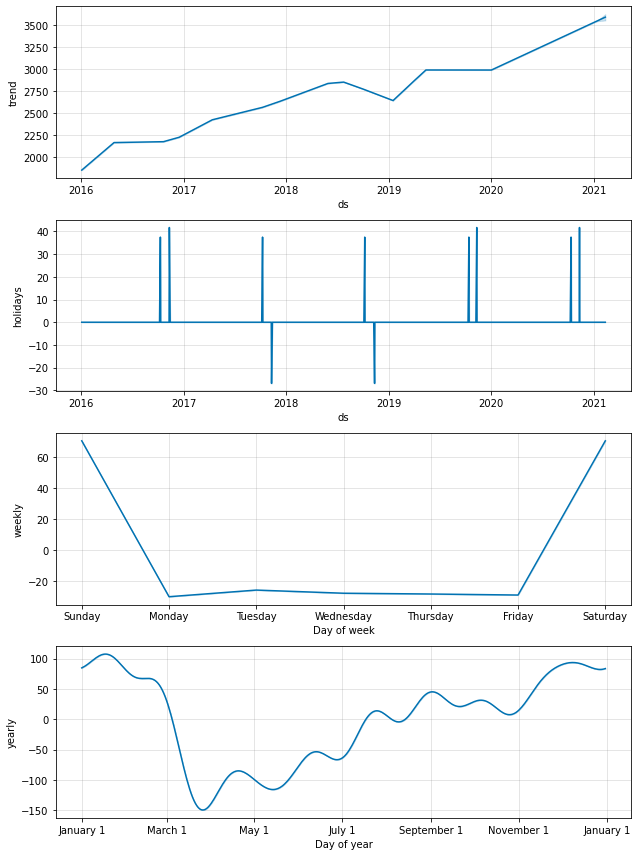

In [9]:
fig = model1.plot_components(forecast)

#### Automatic changepoint detection in Prophet

Prophet automatically detects changepoints when creating the data trend. It first gets a large number of potential changepoints where the rate changes, then it uses a sparse prior on the magnitudes of the rate changes (equivalent to L1 regularization) to reduce the number of changepoints. 

By default, Prophet adds 25 potential changepoints which are uniformly placed in the first 80% of the time-series data. This is done so that the model does not overfit the most recent data points. The default *changepoint_range* parameter works for most problems but can be changed when instantiating the model. In the following cell, we are plotting the changepoints of the fit model.

Note: You can also simply print the changepoints with "model.changepoints"

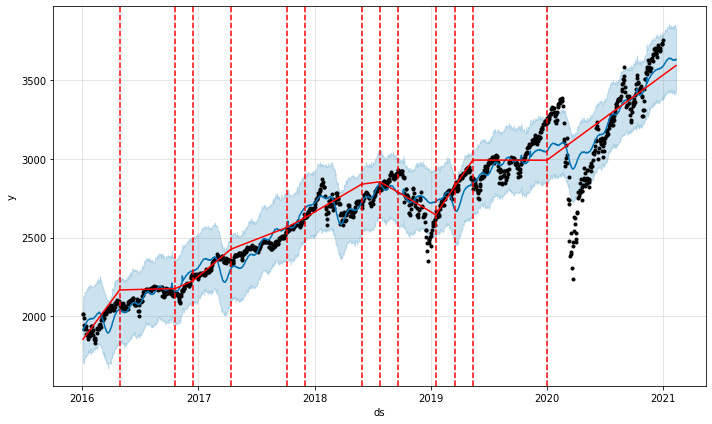

In [10]:
fig = model1.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model1, forecast)

#### Adjusting Trend Flexibility

Another part of the prophet framework that we will explore is adjusting the trend flexibility. This allows us to manually adjust the effect that the trend has on the model. In some cases, we may want to fit more to the trend, and in others we would not. We can adjust this with the changepoint_prior_scale parameter (default: 0.05).

In the following cell, we enter a changepoint_prior_scale value of 0.001. We can see that the model is not following the general trend as much and is rather fitting more to the seasonality.

Initial log joint probability = -5.28897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3512.83   3.58834e-07       4153.37           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       3512.84   5.60077e-07       4971.32   1.088e-10       0.001      182  LS failed, Hessian reset 
     119       3512.84   7.48606e-09       4223.66      0.2213      0.2213      193   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


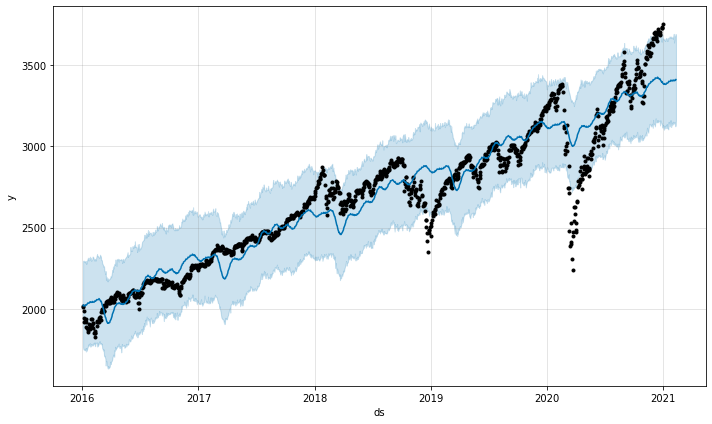

In [11]:
model2 = Prophet(interval_width=0.95, changepoint_prior_scale=0.001)
model2.add_country_holidays(country_name='US')
forecast = model2.fit(sp_sample).predict(future)
fig = model2.plot(forecast)

We can then use the custom_forecast_plot() function that we created earlier in the article to visualize the forecast for the following 30-day period.

We can see that the model is influenced very little by the latest change points, and relies more on the seasonality found in the training data. We can say that the model is underfitting the trend.

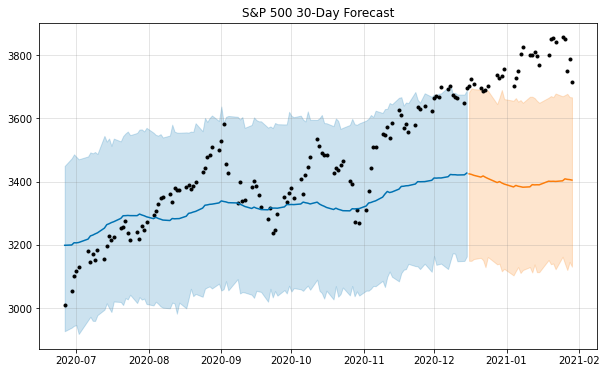

In [12]:
custom_forecast_plot()

We can also increase the value of the changepoint_prior_scale value to magnify the effect of the trend on the forecast.

Initial log joint probability = -5.28897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3732.72     0.0105021       620.263           1           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3871.29    0.00413248       1567.36           1           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       4007.53      0.113873       1469.96       1.629      0.1629      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4040.08    0.00577127       1004.49           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        4076.1       0.12776       4697.63      0.4334           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha  

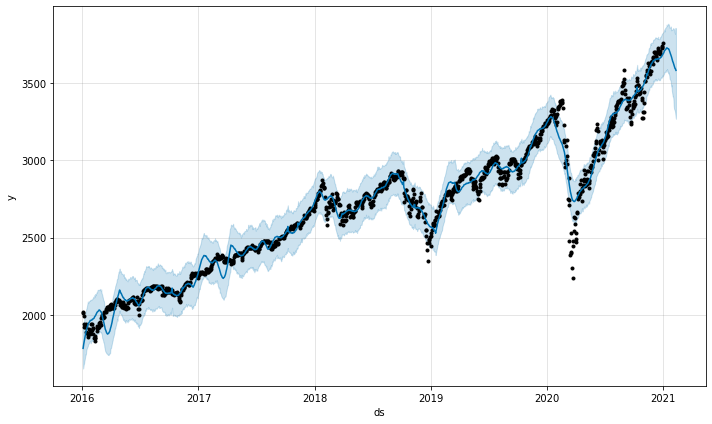

In [13]:
model3 = Prophet(interval_width=0.95, changepoint_prior_scale=0.99)
model3.add_country_holidays(country_name='US')
forecast = model3.fit(sp_sample).predict(future)
fig = model3.plot(forecast)

We can see that in this case, the model actually has a decent forecast at the start of the 30-day period that we are predicting. That being said, the model is under predicting the value of the index in the latter part of the prediction and could be overfitting the data. 

Finding a changepoint_prior_scale value that is optimal for each use case is difficult, and requires a balance of domain knowledge, statistics, and luck in tuning this parameter. It is also important to take into account how far into the future the model needs to forecast.

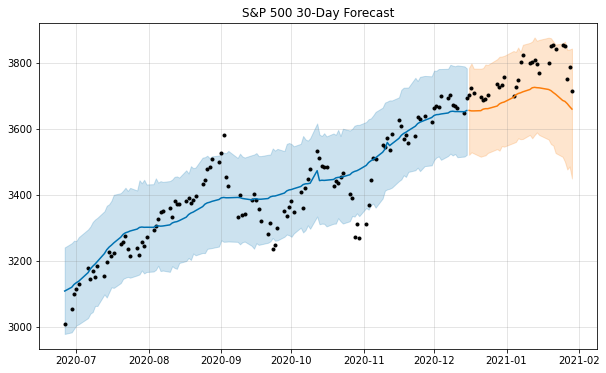

In [14]:
custom_forecast_plot()

The default value of 0.05 for the changepoint_prior_scale parameter seems to work well for this data so we will not tune that further. 

#### Adjusting Seasonality

A significant part of the Prophet model is its incorporation of seasonality. There are many ways we can tune this. 

First of all, the seasonality_prior_scale parameter (default: 10) adjusts how much the model uses seasonality in its forecast. In the following cell, let's decrease this value and see how it affects the model forecast.

Initial log joint probability = -5.28897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3587.35     0.0137682       616.562           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3597.61    0.00935095       459.381           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3599.11   7.04777e-05       126.247      0.3277      0.3277      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     357       3601.15   0.000114853         217.2   7.342e-07       0.001      459  LS failed, Hessian reset 
     399       3602.01   0.000289839       122.813           1           1      505   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     490       3602.48   4.59692e-05    

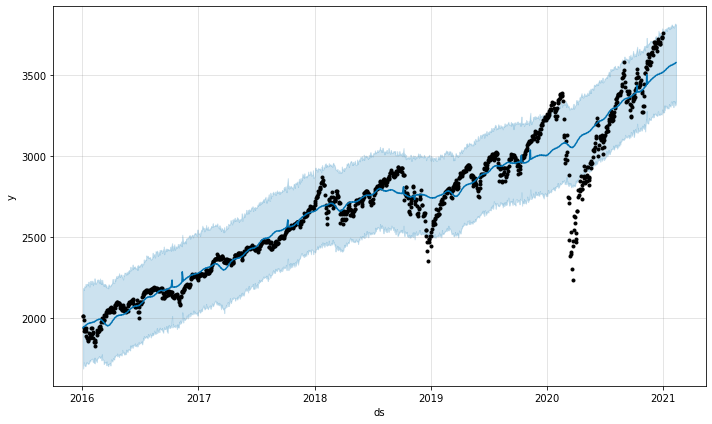

In [15]:
model4 = Prophet(interval_width=0.95, seasonality_prior_scale=0.001)
model4.add_country_holidays(country_name='US')
forecast = model4.fit(sp_sample).predict(future)
fig = model4.plot(forecast)

We can see in the cell above that the model is less affected by seasonality and more closely follows the trend of the data. This is evident when we plot the 30-day forecast after training the model. The prediction is very close to a straight line.

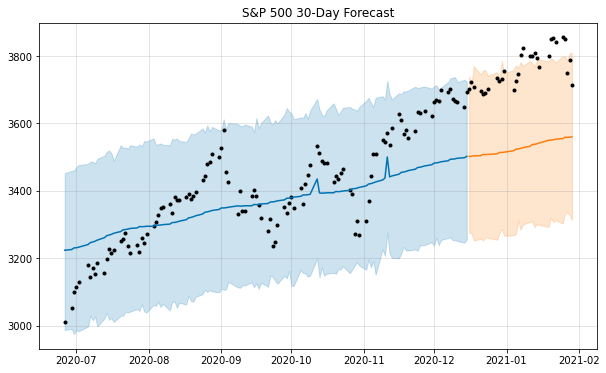

In [16]:
custom_forecast_plot()

Using the seasonality_prior_scale is great, but it affects all the seasonality in the model (hourly, weekly, monthly, yearly, etc.). What if we only want to reduce the effect of the yearly seasonality, but leave the weekly seasonality the same?

We can use input parameters such as yearly_seasonality or weekly_seasonality to do this or we can use the .add_seasonality() function. The latter method requires more work but is much more customizable, and therefore is what I used in this article.

In the following cell, the only two parameters that are different from before are the fourier_order parameter (default: 10), and the weekly_seasonality. The fourier_order parameter determines how quickly the seasonality can change. Let's first look at decreasing this value.

Initial log joint probability = -5.28897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3637.85     0.0194453       173.455      0.8282     0.08282      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       3638.94   9.08935e-05       175.574   5.826e-07       0.001      198  LS failed, Hessian reset 
     199       3644.83    0.00661947       413.119           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3653.56     0.0124395       383.837      0.3265           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3657.24     0.0128534       130.142        1.18       0.118      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     455       3664.55   9.13066e-05    

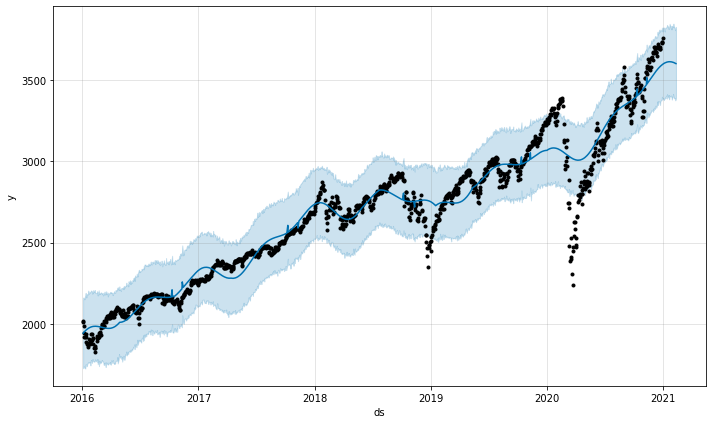

In [17]:
# # Using Simple Example
# model5 = Prophet(yearly_seasonality=2)
# forecast = model5.fit(sp_sample).predict(future)
# fig = model5.plot(forecast)

# More Customizable Example
model5 = Prophet(interval_width=0.95, weekly_seasonality=False)
model5.add_seasonality(name='yearly', period=365, fourier_order=2)
model5.add_country_holidays(country_name='US')
forecast = model5.fit(sp_sample).predict(future)
fig = model5.plot(forecast)

We can see from the following plot how the yearly seasonality is smoothed and follows a much less erratic curve than the default model. Reducing this parameter is one way to combat overfitting to seasonality.

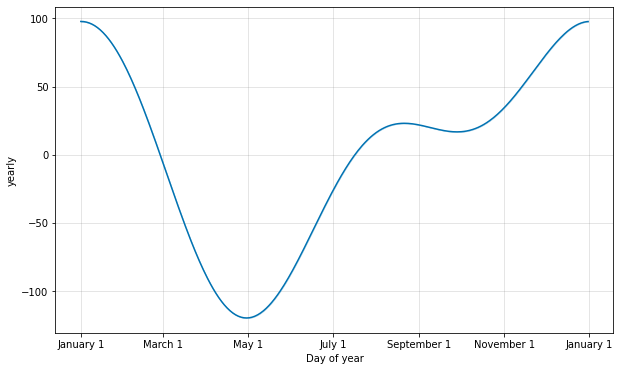

In [18]:
fig = plot_yearly(model5)

We can also increase this parameter to overfit the yearly seasonality. We will do that in the following cell by scaling the fourier_order value by a factor of 10 to 100.

Initial log joint probability = -5.28897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3720.59    0.00615474       382.282           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3734.14    0.00784236       264.146           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       3734.27   8.04199e-05       156.086   2.506e-07       0.001      278  LS failed, Hessian reset 
     299       3741.06     0.0140596       373.642      0.5423           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       3745.08    0.00224354       492.694      0.3108      0.3108      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     424       3748.32   0.000408923    

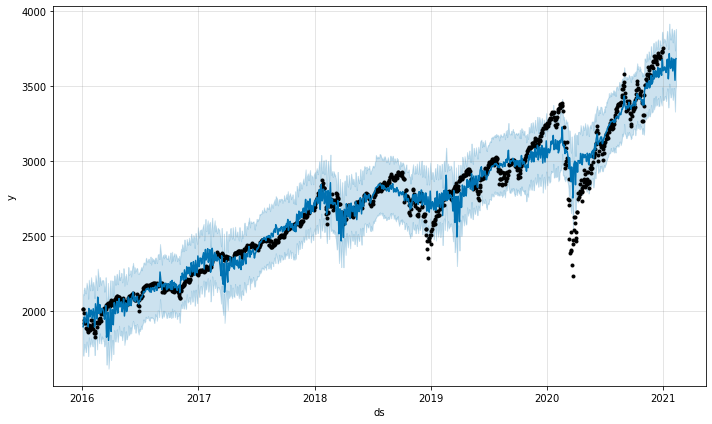

In [19]:
model6 = Prophet(interval_width=0.95, weekly_seasonality=False)
model6.add_seasonality(name='yearly', period=365, fourier_order=100)
model6.add_country_holidays(country_name='US')
forecast = model6.fit(sp_sample).predict(future)
fig = model6.plot(forecast)

We can see in the following plot how much more the model is responding to annual seasonality, and in turn overfitting to the data.

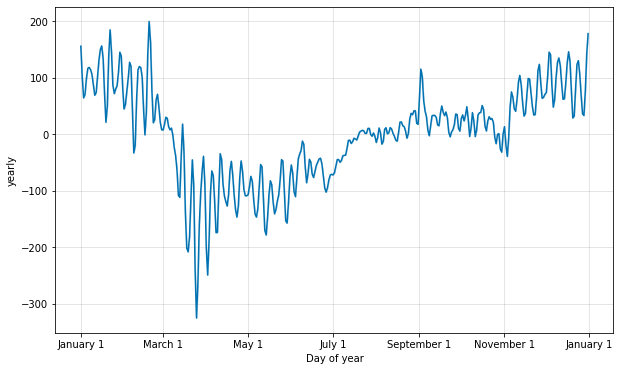

In [20]:
fig = plot_yearly(model6)

In the case of the data we are working with, a value slightly lower than the default would be optimal.

---

So, for the final model, we are removing the weekly_seasonality, increasing the effect of changepoints, and reducing the effect of yearly seasonality. All these changes can be done with the following code.

Initial log joint probability = -5.28897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3702.29    0.00907862       2114.92      0.3462      0.3462      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       3851.12    0.00420937       280.737       0.899       0.899      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       3931.37    0.00242274       512.784           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       4028.79      0.132936        1419.2           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       4078.39    0.00101852       336.198      0.4166      0.9288      566   
    Iter      log prob        ||dx||      ||grad||       alpha  

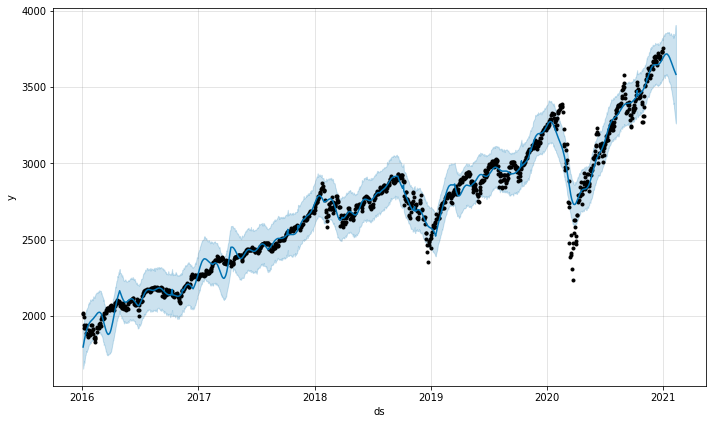

In [21]:
final_model = Prophet(interval_width=0.95, weekly_seasonality=False, changepoint_prior_scale=0.9)
final_model.add_seasonality(name='yearly', period=365, fourier_order=8)
final_model.add_country_holidays(country_name='US')
forecast = final_model.fit(sp_sample).predict(future)
fig = final_model.plot(forecast)

Given how we are simply using the index value, and not passing in additional variables, this model performs quite well! In the forecast following the data we trained on, the model is able to make accurate predictions for about 15 days, then the accuracy of the forecast is lower than expected yet follows the right trend.

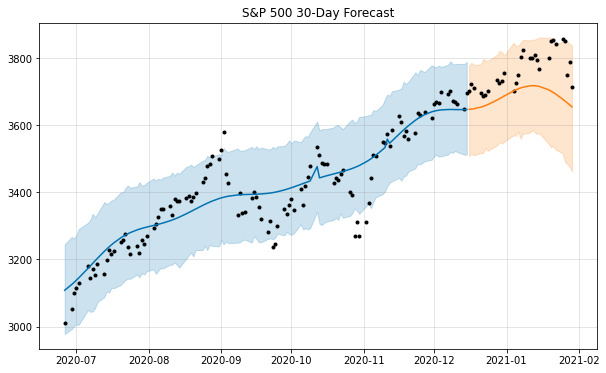

In [22]:
custom_forecast_plot()

#### Closing Thoughts

Prophet is awesome. It is very fast, powerful, easy to implement, and highly customizable. I would say that it is my favorite forecasting framework as of this writing.

There are many components in the framework that I did not showcase in this article. These include adding additional regressors, providing custom changepoints, cross-validation, and hyperparameter tuning. 

In this article, I made predictions solely on past S&P index values. I believe that even more predictive power could be unleashed using other data (current events, volatility, lending rates, etc.). This could be done through model blending with an LGBM/XGB regressor, and a tuned prophet-based model. 

I enjoy learning with hands-on examples and putting ideas into my own words. Hopefully, this article can motivate others to do the same!

### References

1. https://journalofbigdata.springeropen.com/articles/10.1186/s40537-020-00333-6

2. https://www.gobankingrates.com/investing/strategy/what-you-need-know-about-seasonal-stock-trends/
